### <left><b><font size=4>Section 3 – Unsupervised Learning – Clustering<b><left>

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
# from sklearn.decomposition import PCA
import umap

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score

<div style="text-align: justify">Cluster the attacks according to their characteristics. Choose at least 2 Clustering Algorithms, and for each of them solve the following points.</div>

In [3]:
if not (os.path.isfile("df_features_bow_sampled.parquet") and os.path.isfile("df_features_tfidf_sampled.parquet")):
    raise Exception("You should run the section 1 before")
df_features_bow_sampled = pd.read_parquet("df_features_bow_sampled.parquet")
df_features_tfidf_sampled = pd.read_parquet("df_features_tfidf_sampled.parquet")


X = df_features_tfidf_sampled.drop(columns=["Set_Fingerprint"])
X

,enable,system,sh,cat,proc,mounts,bin,busybox,cd,dev,...,awk,print,free,which,crontab,top,passwd,mv,nohup,tsm
170871,0.086522,0.0,0.130895,0.0,0.0,0.0,0.160000,0.000000,0.0,0.0,...,0.000000,0.0,0.388253,0.043175,0.0,0.129794,0.0,0.475538,0.000000,0.043269
88992,0.071382,0.0,0.107990,0.0,0.0,0.0,0.132002,0.000000,0.0,0.0,...,0.000000,0.0,0.320313,0.035619,0.0,0.107081,0.0,0.392324,0.000000,0.035697
230337,0.086522,0.0,0.130895,0.0,0.0,0.0,0.160000,0.000000,0.0,0.0,...,0.000000,0.0,0.388253,0.043175,0.0,0.129794,0.0,0.475538,0.000000,0.043269
138803,0.086522,0.0,0.130895,0.0,0.0,0.0,0.160000,0.000000,0.0,0.0,...,0.000000,0.0,0.388253,0.043175,0.0,0.129794,0.0,0.475538,0.000000,0.043269
191558,0.079382,0.0,0.120093,0.0,0.0,0.0,0.146797,0.000000,0.0,0.0,...,0.000000,0.0,0.356213,0.039612,0.0,0.119083,0.0,0.436295,0.000000,0.039698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171360,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
166018,0.000000,0.0,0.099894,0.0,0.0,0.0,0.045790,0.318229,0.0,0.0,...,0.088489,0.0,0.148151,0.000000,0.0,0.000000,0.0,0.395907,0.477025,0.000000
132486,0.000000,0.0,0.123187,0.0,0.0,0.0,0.028234,0.196216,0.0,0.0,...,0.054561,0.0,0.121797,0.000000,0.0,0.000000,0.0,0.457709,0.294128,0.000000
171506,0.000000,0.0,0.127276,0.0,0.0,0.0,0.029171,0.101364,0.0,0.0,...,0.000000,0.0,0.157300,0.000000,0.0,0.000000,0.0,0.504428,0.000000,0.000000


<div style="text-align: justify"> Two clustering algorithms will be implemented to our dataset, the chosen were MiniBatchK-Means and Gaussian Mixture Model (GMM). <br>
First of all we have to select the features to be evaluate, <b>'Pricipal Component Analysis (PCA)'</b> was used to reduce the dimensionality of the data.</div>


What are these parameters? 
- **Silhouette**: is a score that measures how similar is an object to its own cluster, compared to other clusters.
              The range of values that the Silhouette can assume is from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters, so a good clustering structure.


- **RI(Rand Index)**:  is a measure of similarity among two clusterings. The range of values that Rand Index can assume is from 0 to 1,                     where a value of 1 indicates perfect similarity between two clusterings and a value of 0 indicates no similarity.


- **ARI(Adjusted Rand Index)**: it'a a way to "correct" the RI, a sort of normalization of it.
                                ARI ranges from -1 to 1, where a value close to 1 indicates strong agreement between two clusterings, a value close to 0 indicates random clustering, and negative values indicate disagreement.



**3.1. Determine the number of clusters: This can be done using methods like the elbow method or
silhouette analysis. Explain your reasoning.**

<div style="text-align: justify"> The clustering error is strongly dependent form the number of cluster. 
The best situation, with the lowest error possible, is obiuously when we have the same number of clusters of the datapoins. Actually in this situation we're not even performing clustering, but the clustering error will be zero.<br>
<br>
Now we want to find the number of clusters that gives us the best results, so with the lowest clustering error. 
We'll follow 2 approches for each clustering algorithm applied, elbow method and validation error. </div>

In particular now we are finding the best number of clusters leaving all the other hyperparameters as default. Then we'll try to tune them in order to obtain even better resutls.

#### K-Means Algorithm

In [4]:
# Step 1: Elbow Method  (260 sec)
n_cluster_list=[]
inertia_list=[]
silhouette_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 17):
    kmeans_new = KMeans(n_clusters=n_clusters)
    cl_labels = kmeans_new.fit_predict(X)
        
    # Unsupervised metric  (it takes approx 2500 sec o 3000 sec)
    silhouette_value= silhouette_score(X, kmeans_new.labels_)
    silhouette_list.append(round(silhouette_value,2))

    # For Elbow Method (Inertia):
    inertia_list.append(kmeans_new.inertia_)
    n_cluster_list.append(n_clusters)


/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/clus

In [5]:
n_cluster_list=[]
inertia_list=[]
silhouette_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 17):
    kmeans_new = KMeans(n_clusters=n_clusters)
    cl_labels = kmeans_new.fit_predict(X)
        
    # Unsupervised metric  (it takes approx 2500 sec o 3000 sec)
    silhouette_value= silhouette_score(X, kmeans_new.labels_)
    silhouette_list.append(round(silhouette_value,2))

    # For Elbow Method (Inertia):
    inertia_list.append(kmeans_new.inertia_)
    n_cluster_list.append(n_clusters)


/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/clus

**Elbow Method**

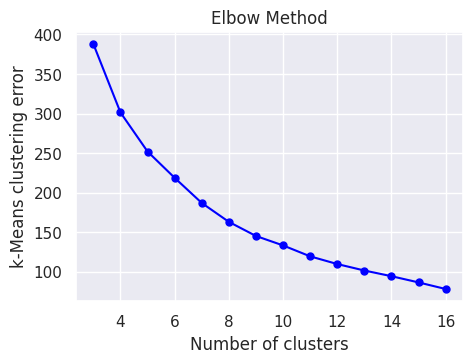

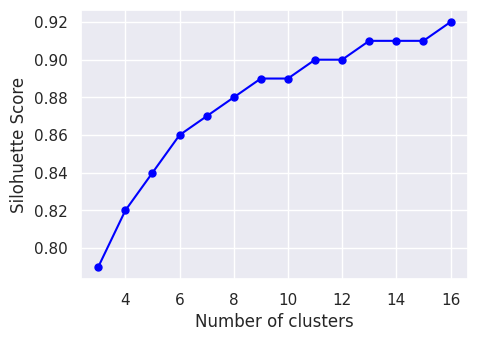

Size of each cluster:  [2117 2569  441   50  237  125   72   42   10   17   61   25   35   16
   18   18]


In [6]:
# Step 3
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, silhouette_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silohuette Score')
plt.title('')
plt.show()

(unique, counts) = np.unique(kmeans_new.labels_, return_counts=True)
print("Size of each cluster: ", counts)

So for the given metrics, a good number of clusters could be 9.

#### Gaussian Mixture Model Algorithm (GMM)

In [7]:
n_cluster_list=[]
silhouette_list_gmm= []
log_l_list=[]

for n_clusters in range(3, 17):
    gmm = GaussianMixture(n_components = n_clusters)
    gmm_label = gmm.fit_predict(X)
      
    silhouette_value = silhouette_score(X, gmm_label)
    silhouette_list_gmm.append(round(silhouette_value,2))
    
    log_l_list.append(gmm.score(X))
    n_cluster_list.append(n_clusters)

**Elbow Method**

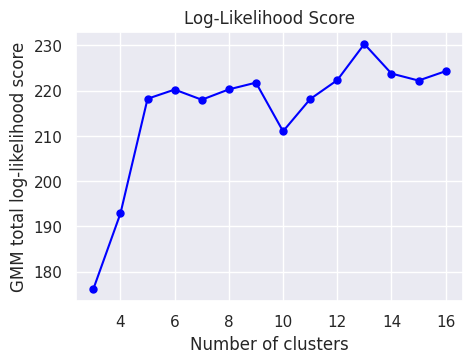

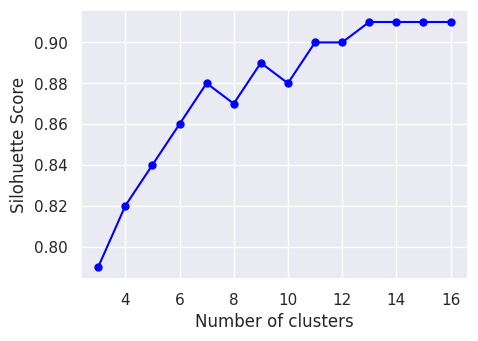

Effetive size of each cluster:  [0.36186571 0.44284982 0.07534598 0.00854263 0.04100461 0.02135657
 0.00444217 0.00290449 0.01230138 0.00375876 0.00170853 0.00341705
 0.01042201 0.00307535 0.00392961 0.00307535]


In [8]:
#3. Has the performance improved also on the other metrics? Plot the other metrics for the different values of n_cluster.
# Set up Seaborn style
sns.set(style="darkgrid")

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, log_l_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('Log-Likelihood Score')
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, silhouette_list_gmm, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silohuette Score')
plt.title('')
plt.show()

# report effective size
print("Effetive size of each cluster: ", gmm.weights_)

Log Likelihood value is a measure of goodness of fit for any model. Higher the value, better is the model.

We should remember that Log Likelihood can lie between -Inf to +Inf. Hence, the absolute look at the value cannot give any indication. We can only compare the Log Likelihood values between multiple models.

Even in this case, a good number of clusters semms to be 9.


**3.2. Tune other hyper-parameters, if any.**

When trying to learn a good function to model data,
there are usually parameters that one must specify before
learning starts. These hyperparameters generally either
parametrize a family of models to be learned, or optimization
methods to learn them. Choosing the correct hyperparameters
determines the success of the model and generally involves
manual tuning.


##### Tuning the hyper-parameter of K-Means


As seeen previously a good number of clusters for K-Means is 9. So now the tuning will be applied to a K-Means with this number of clusters, focusing on the following hyperparameters:
- **Initialization method(init) and iterations(n_init)**: In K-Means is crucial to choose in a correct way the initialization centroids. A bad initialization can be for instace a set of centroids far from the clusters, that can bring the algorithm to reach just a local optimum value, instead of the optimal clustering.
So in sk_learn there is the n_init hyper parameter that set the number of times that the algorithm is executed with different clustering seed. Then the best one will be taken, based on the inertia (sum of squared distances from each point to its assigned centroid).
By defalut n_init = 10, but in the new version of n_init there is an 'auto' setting that find automatically the best number. 
However, now we'll try to investigate a little bit.
Another hyperparameter related to initialization is the method that will be use to set these centroids. So far we said that we need to choose the number of times that the algorithm will be executed with different centroids seed, but how to choose this seeds? This can be done randomly or passing the position of the centroids. However the the best method found is k-means++, that now we'll use for the next esperiments.

- **Maximum number of iterations (max_iter)**: As we know the K-means is an iterative algorithm, and in each step the centroids are recomputed and the datapoints reassigned. Thus, the maximum number of iteration is an hyperparameter that set a treshold upon which the algorithm should stop.
By default, the MN of iteration is 300, but which is the best value in our case? 



Now, using k-means++ as initialization methd with 9 clusters, let's figure out which are the best hyperparameters for the number of initializations and the number of interation.
For this purpose we'll use  GridSearchCV, that is basically an optimised function that explores all the possible combinations of parameters, where we set the range that we prefer for each of them

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_init':  list(range(2, 21, 2)),
    'max_iter':  list(range(50, 501, 50)) 
}

# Create KMeans object
kmeans = KMeans(n_clusters=9, init='k-means++')

# Create RandomizedSearchCV object
random_search = GridSearchCV(kmeans, param_grid, cv=5)

# Fit the randomized search to your data
random_search.fit(X)  # X is your dataset

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters:", best_params)


Best parameters: {'max_iter': 450, 'n_init': 20}


So summarising, the best hyperparameters that should be used for k-means in our case are: 
- Number of clusters: 9
- Initialization method: k-means++
- Number of initializations: 10
- Maximum number of iterations of the algorithm: 400

Let's analyse briefly the results:

In [10]:
kmeans_tuned = KMeans(n_clusters=9, init='k-means++', n_init=10, max_iter=400)
cl_labels_tuned = kmeans_tuned.fit_predict(X)
    
silhouette_value= silhouette_score(X, kmeans_tuned.labels_)

inertia = (kmeans_tuned.inertia_)
print("Silhouette: ", silhouette_value)
print("Inertia: ", inertia)



Silhouette:  0.8813743621432707
Inertia:  149.33103859379605


##### Tunning the hyper-parameters of GMM 

As we found above, the best number of clusters is 9. Now what are the hyperparameters that may be tuned?
- **Covariance type (covariance_type)**: as already discussed, in GMM each cluster is a component, a gaussian bell,with it's variance, mean, and so on. With this hyperparameter we're gonna set the type of covariance matrix to be used, and we'll test these possibilities: 
    - 'full': Each component has its own general covariance matrix.
    - 'tied': All components share the same general covariance matrix.
    - 'diag': Each component has its own diagonal covariance matrix (no correlation between features).
    - 'spherical': Each component has its own single variance (spherical shape) covariance matrix.
The covariance type will affect the shape of the clusters.

- **Method of initialization(init_params)**: the initialization method for the parameters of the Gaussian distributions. There are basically 2 option, kmeans and random. We'll use kmeans.

- **Number of iteration of the algorithm (max_iter)**: the maximum number of iterations for the EM algorithm. It determines how many iterations the algorithm will perform before stopping.
By deafult the max_iter is equal to 100. We'll try some other value.

- **Convergence tolerance (tol)**: This parameter controls the convergence tolerance of the Expectation-Maximization (EM) algorithm used to fit the GMM. It specifies the threshold for the change in the log-likelihood of the data between successive iterations, below which the algorithm stops iterating.


In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'init_params': ['kmeans'], 
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': [1e-3, 1e-4, 1e-5], 
    'max_iter': list(range(50, 300, 50))
}

# Create GaussianMixture object
gmm = GaussianMixture(n_components=9)

# Create GridSearchCV object
grid_search = GridSearchCV(gmm, param_grid, cv=5)

# Fit the grid search to your data
grid_search.fit(X)  # X is your dataset

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'covariance_type': 'spherical', 'init_params': 'kmeans', 'max_iter': 200, 'tol': 0.001}


So summarising, the best hyperparameters that should be used for GMM in our case are: 
- Number of clusters: 9
- Initialization method: kmeans
- Maximum number of iterations of the algorithm: 200
- Covariance type: spherical
- Convergence tolerance: 0.0001

Let's analyse briefly the results:

In [12]:
gmm_tuned = GaussianMixture(n_components = 9, init_params='kmeans', covariance_type='spherical', max_iter=200, tol=0.0001)
gmm_label_tuned = gmm_tuned.fit_predict(X)
    
silhouette_value = silhouette_score(X, gmm_label_tuned)

log_l_tuned = (gmm_tuned.score(X))

print("Silhouette: ", silhouette_value)
print("Log-l: ", log_l_tuned)



Silhouette:  0.8383907123066577
Log-l:  251.83734164981112


**3.3. Visualize the clusters through t-SNE visualization.**

Let's apply the k-mean clustering algorithm with the best hyper-parameters found, using the optimal number of cluster.

**K-Means Algorithm**

In [13]:
from sklearn.manifold import TSNE


kmeans_tuned = KMeans(n_clusters=9, init='k-means++', n_init=10, max_iter=400)
cl_labels3 = kmeans.fit_predict(X) # Using the features selected


/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The goal of t-SNE is to take a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space, typically the 2D plane.

In [14]:
# Just in case, you run the belowe column twice creating two columns for cluster column
#X = X.drop(['cluster','Cluster'], axis=1)

In [15]:
df_cluster = pd.DataFrame(X)
df_cluster['cluster'] = cl_labels3

In [16]:
component = df_cluster.iloc[:,:-1]
#print(component)
tsne = TSNE(n_components=2).fit_transform(component)

df_tsne = pd.DataFrame(tsne)
df_tsne["cluster"] = cl_labels3
df_tsne.columns = ["x1", "x2", "cluster"]
df_tsne

,x1,x2,cluster
0,27.568769,29.019762,1
1,-15.437375,4.231022,1
2,27.418800,29.453459,1
3,27.458946,29.309683,1
4,48.289558,5.977299,1
...,...,...,...
5848,-30.343876,-9.804677,8
5849,-47.461658,-8.470747,0
5850,-47.463844,-8.446864,0
5851,-47.426094,-8.407888,6


/tmp/ipykernel_67922/3969356608.py:5: UserWarning: 
The palette list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_tsne, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full", alpha=0.5)


(-60.0, 50.0)

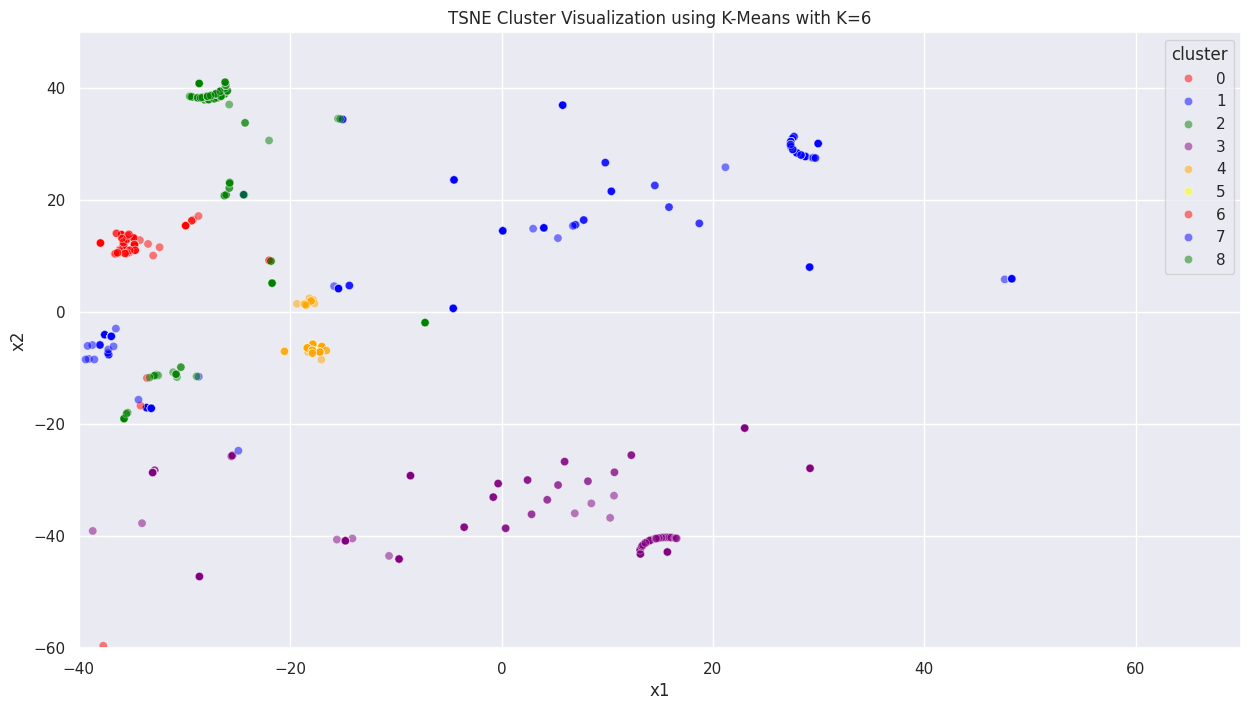

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
#custom color palette, to distinguish beter the clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "yellow"] #"brown", "teal", "black"]

sns.scatterplot(data=df_tsne, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full", alpha=0.5)
ax.set_title('TSNE Cluster Visualization using K-Means with K=6')

ax.set_xlim([-40, 70])  
ax.set_ylim([-60, 50])  

**GMM Algortihm**

In [18]:
# Fit KMeans with the optimal number of clusters
optimal_clusters_gmm = 6
gmm_final = GaussianMixture(n_components = 9, init_params='kmeans', covariance_type='spherical', max_iter=200, tol=0.0001)
# BEAWARE: use df_cluster.iloc[:,:-1] to exclude the cluster column assigned by k-means, created before
labels_gmm_final = gmm_final.fit_predict(df_cluster.iloc[:,:-1])
    
# Add cluster labels to the DataFrame
df_cluster['cluster_gmm'] = labels_gmm_final

In [19]:
# Excluding the last two columns corresponding to the cluster assigned by k-meand and gmm
component_1 = df_cluster.iloc[:,:-2]
#print(component)
tsne_1 = TSNE(n_components=2).fit_transform(component_1)

df_tsne_gmm = pd.DataFrame(tsne_1)
df_tsne_gmm["cluster"] = labels_gmm_final
df_tsne_gmm.columns = ["x1", "x2", "cluster"]
df_tsne_gmm

,x1,x2,cluster
0,27.568769,29.019762,0
1,-15.437375,4.231022,7
2,27.418800,29.453459,0
3,27.458946,29.309683,0
4,48.289558,5.977299,7
...,...,...,...
5848,-30.343876,-9.804677,7
5849,-47.461658,-8.470747,7
5850,-47.463844,-8.446864,7
5851,-47.426094,-8.407888,7


/tmp/ipykernel_67922/3660157601.py:5: UserWarning: 
The palette list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = df_tsne_gmm, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full", alpha=0.5)


(-60.0, 50.0)

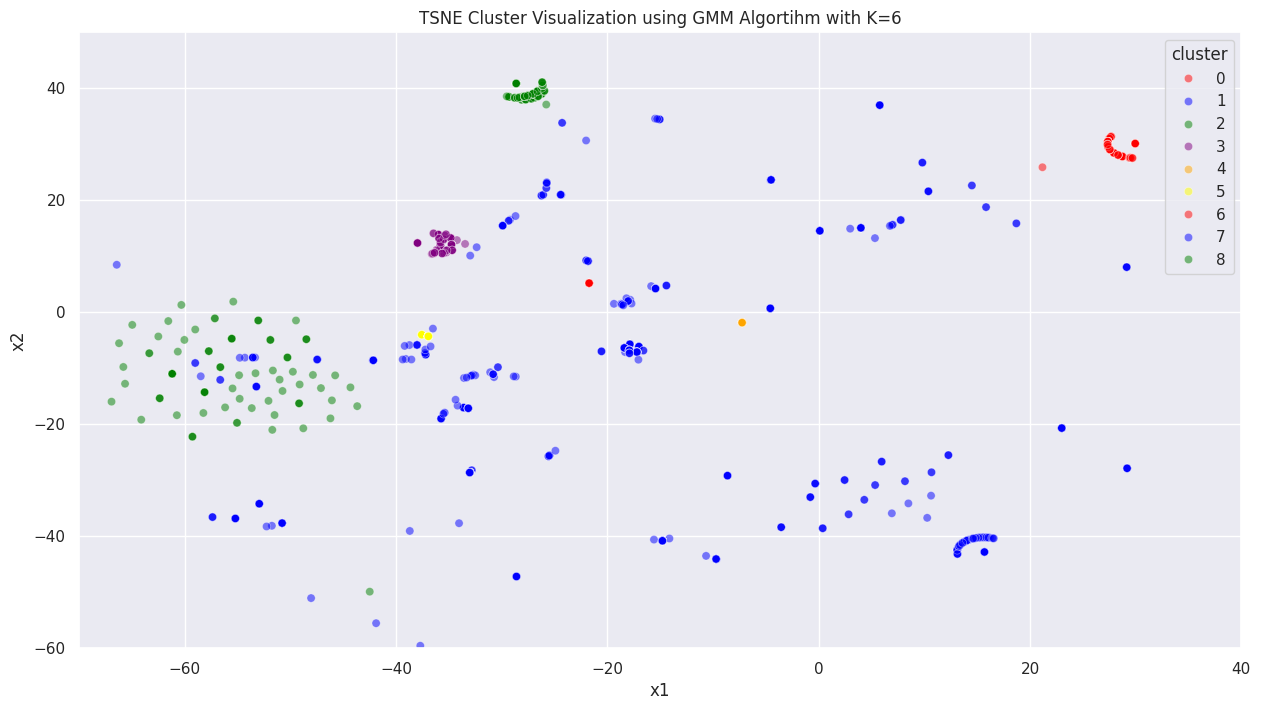

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
#custom color palette, to distinguish beter the clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "yellow"] #"brown", "teal", "black"]

sns.scatterplot(data = df_tsne_gmm, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full", alpha=0.5)
ax.set_title('TSNE Cluster Visualization using GMM Algortihm with K=6')

ax.set_xlim([-70, 40])  
ax.set_ylim([-60, 50])  

**3.4. Cluster analysis. Analyze the characteristics of each cluster. This might involve examining the most frequent words in each cluster (try word cloud). Try to understand which are the most
representative.**

##### Most Frequent Words for the K-Means Cluster Algorithm

IndexError: index 2 is out of bounds for axis 0 with size 2

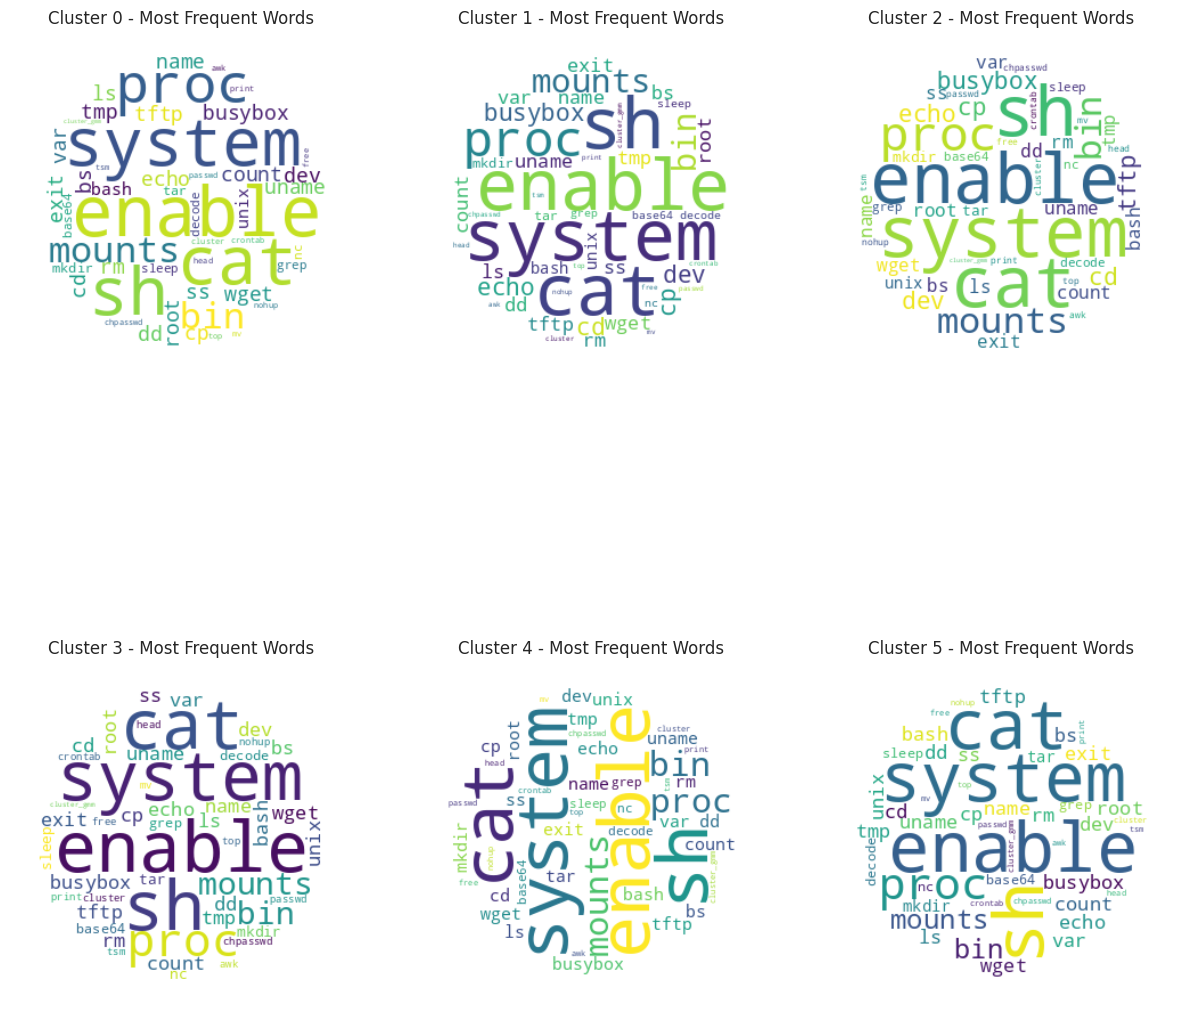

In [21]:
optimal_clusters = 9  # Optimal number of clusters

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
    
for cluster in range(optimal_clusters):
    cluster_data = df_cluster[df_cluster['cluster'] == cluster]
    cluster_text = ' '.join(cluster_data)
    
    # Circle maskdf_cluster
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    
    # Generate WordCloud
    wordcloud = WordCloud(width=400, 
                          height=400, 
                          background_color='white', 
                          colormap = "viridis", 
                          mask = mask,
                          contour_color='grey').generate(cluster_text)
    
    # Plot WordCloud on the corresponding subplot
    row_index = cluster // 3
    col_index = cluster % 3
    
    # plt.figure(figsize=(6, 4))
    axes[row_index, col_index].imshow(wordcloud, interpolation='bilinear')
    axes[row_index, col_index].set_title(f'Cluster {cluster} - Most Frequent Words')
    axes[row_index, col_index].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

##### Most Frequent Words for the GMM Cluster Algorithm

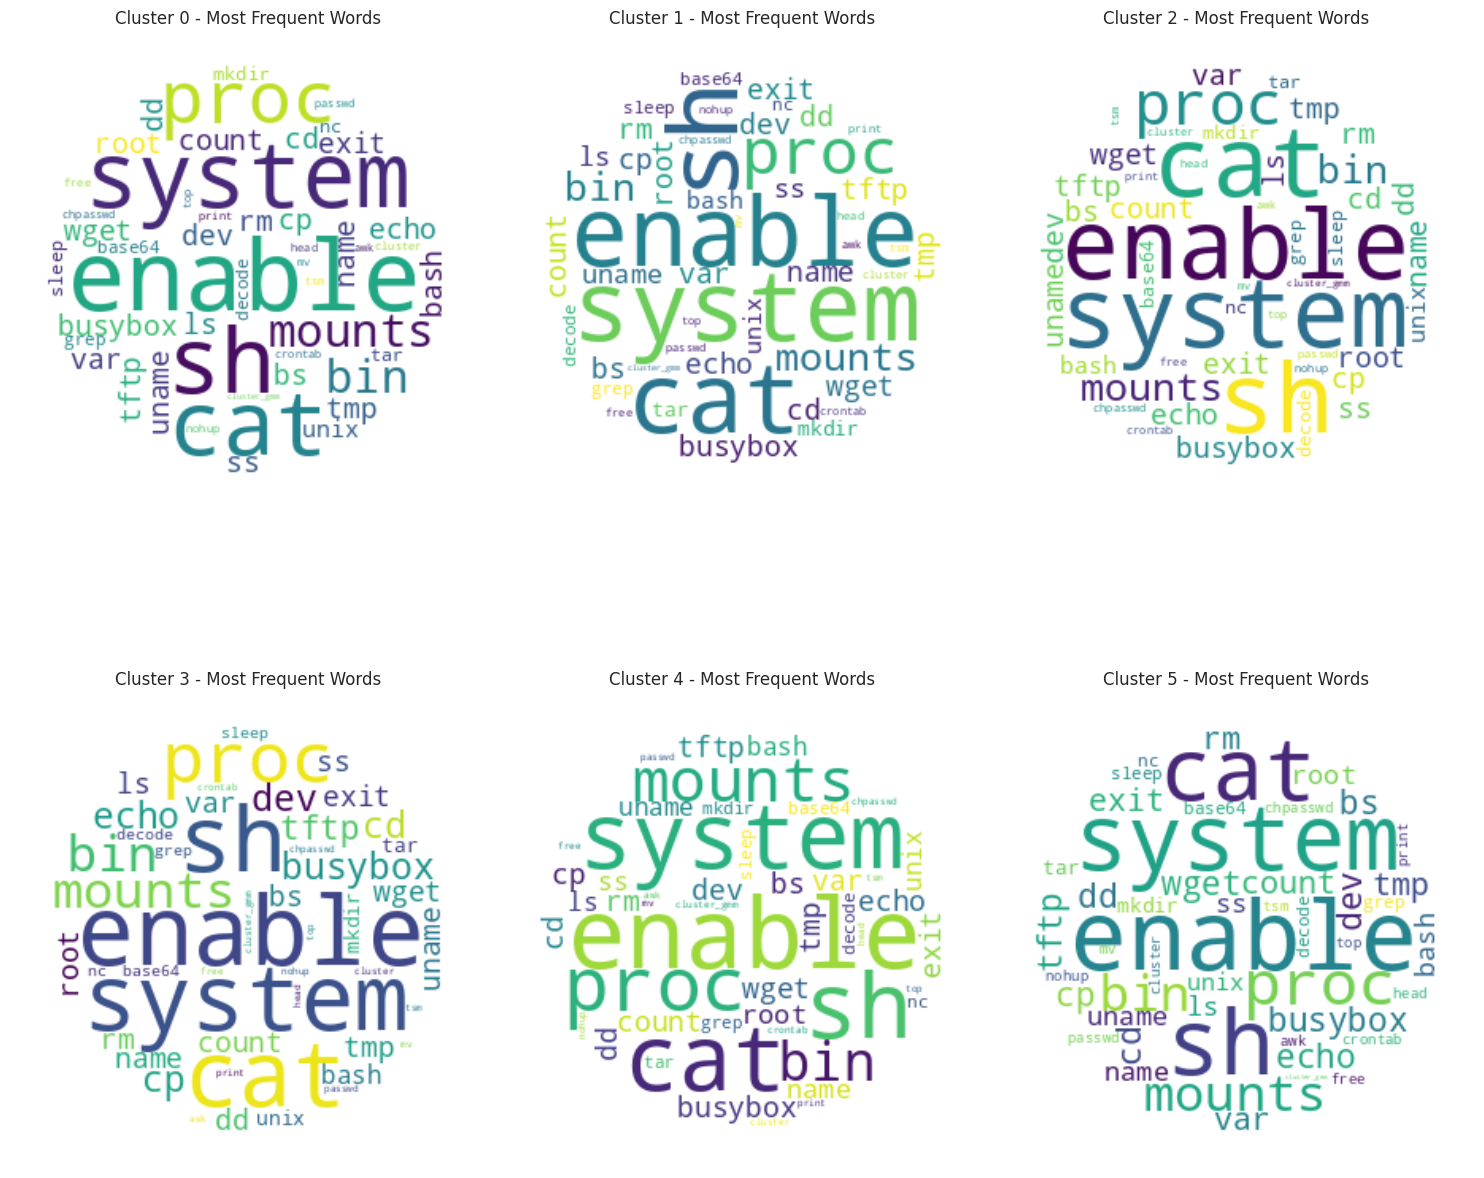

In [ ]:
optimal_clusters = 6  # Optimal number of clusters

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
for cluster in range(optimal_clusters):
    cluster_data = df_cluster[df_cluster['cluster_gmm'] == cluster]
    cluster_text = ' '.join(cluster_data)
    
    # Circle mask
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    
    # Generate WordCloud
    wordcloud = WordCloud(width=400, 
                          height=400, 
                          background_color='white', 
                          colormap = "viridis", 
                          mask = mask,
                          contour_color='grey').generate(cluster_text)
    
    # Plot WordCloud on the corresponding subplot
    row_index = cluster // 3
    col_index = cluster % 3
    
    # axes settings 
    axes[row_index, col_index].imshow(wordcloud, interpolation='bilinear')
    axes[row_index, col_index].set_title(f'Cluster {cluster} - Most Frequent Words')
    axes[row_index, col_index].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

**3.5. Do clusters reflect intent division, i.e., are the clusters homogeneous in terms of intents? How are intents divided into the clusters?**

In [ ]:
# Adding the Fingerprint column to df_cluster 
df_cluster['Set_Fingerprint'] = df_features_tfidf_sampled['Set_Fingerprint']
#df_cluster

In [ ]:
df_cluster_exploded = df_cluster.explode("Set_Fingerprint").reset_index()
df_cluster_exploded = df_cluster_exploded.drop(columns=['index','cluster_gmm'])

# # We should use the stardardized data (X and y features)
labels_intents = df_cluster_exploded["Set_Fingerprint"]
cluster_labels = df_cluster_exploded["cluster"]

##### Intents Division into the K-Means Clusters

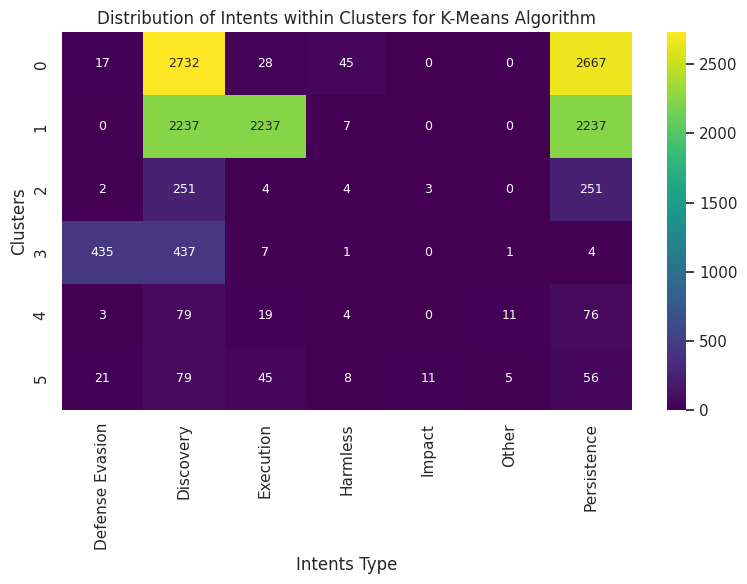

In [ ]:
# Predicted cluster labels for the optimal number of clusters
# Creating a data frame with the original labels and the labels predicted by the cluster
# and regrouping them according to the cluster's label
cluster_df = pd.DataFrame({'Set_Fingerprint': labels_intents, 'Cluster': cluster_labels})
cluster_counts = cluster_df.groupby('Cluster')['Set_Fingerprint'].value_counts().unstack(fill_value=0)

# Cluster distribution
cluster_counts

# Distribution plot of intents within the Clusters
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_counts, annot=True, fmt='d', cmap='viridis', annot_kws={"size": 9})
plt.title('Distribution of Intents within Clusters for K-Means Algorithm')
plt.xlabel('Intents Type')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

##### Intents Division into the GMM Clusters

In [75]:
df_cluster_exploded = df_cluster.explode("Set_Fingerprint").reset_index()
df_cluster_exploded = df_cluster_exploded.drop(columns=['index','cluster'])

# # We should use the stardardized data (X and y features)
labels_intents_gmm = df_cluster_exploded["Set_Fingerprint"]
cluster_labels_gmm = df_cluster_exploded["cluster_gmm"]

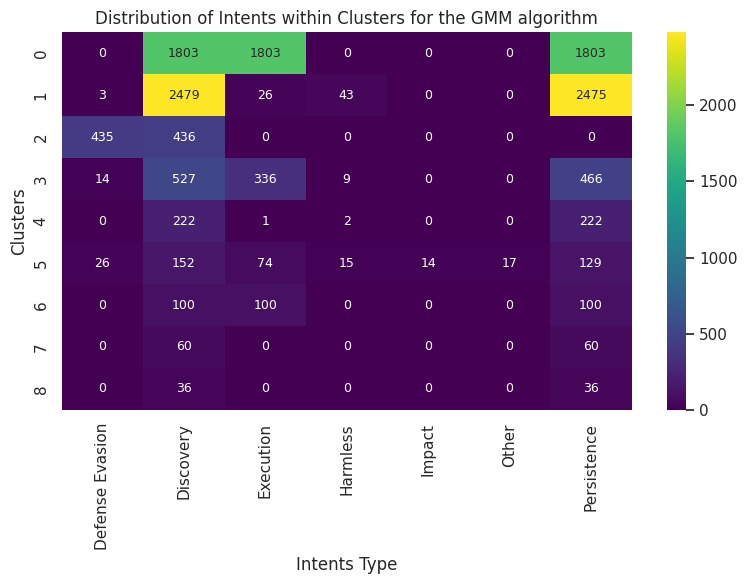

In [76]:
# Predicted cluster labels for the optimal number of clusters
# Creating a data frame with the original labels and the labels predicted by the cluster
# and regrouping them according to the cluster's label
cluster_gmm_df = pd.DataFrame({'Set_Fingerprint': labels_intents_gmm, 'Cluster': cluster_labels_gmm})
cluster_counts_gmm = cluster_gmm_df.groupby('Cluster')['Set_Fingerprint'].value_counts().unstack(fill_value=0)

# Cluster distribution
cluster_counts_gmm

# Distribution plot of intents within the Clusters
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_counts_gmm, annot=True, fmt='d', cmap='viridis', annot_kws={"size": 9})
plt.title('Distribution of Intents within Clusters for the GMM algorithm')
plt.xlabel('Intents Type')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

**3.6. Find clusters of similar attacks, study their sessions and try to associate with them specific categories of attacks (more fine grained than the ones of MITRE ATT&CK Tactics). As an example, see the image below, where we perform a similar exercise (through graph community detections). NOTE: you do not have to do this exercise for all the clusters, but only on some examples.**